# Udacity Capstone Project
Stock market prediction in this capstone project is treated as a classification problem, where the objective is to predict whether the cumulative returns of a stock over a period of one day will be greater than zero (up) or smaller (down). The final algorithm has to return (1) the predicted label and (2) a confidence level. 

The final classification algorithm will be used in a long/short equity trading strategy. Using a ranking scheme based on both the predicted label and the algorithms confidence the strategy goes long on (buys) the top x% of equities of the ranking and goes short on (sells) the bottom x% of the ranking, while maintaining equal dollar volume between the long and short position (Granizo-Mackenzie). The implementation of the machine learning algorithm is out of the scope of this capstone project, yet relevant for the implementation of the algorithm and its evaluation metric.

This Capstone project will follow the Professional Quant Equity Workflow proposed by Jonathan Larkin, Chief Investment Officer at Quantopian.

1. **Data** — There are endless data sources available, yet most are locked behind a paywall. Researching datasets and ultimately selecting datasets will influence the performance of the algorithm greatly
2. **Stock Universe** — Thousands of securities can be traded, which doesn’t imply that one should consider these stocks in their trading strategy.Using the TradableUS Methodology (Wassermann, 2016) to select a set of 500 stocks that are tradable, liquid, financially viable and represent sectors equally at the beginning of the training time to avoid survivor bias.
3. **Alpha Discovery** — I’ll be calculating fundamental and technical indicators (alphas) for the stock universe. Each alpha will be evaluated using the `alphalens` package to determine whether the alpha is predictive of future returns.
4. **Alpha Combination** — I intend to develop a system that is an ensemble of multiple machine learning classifiers that combine the individual alphas. The goal of ensembles is that the performance of the entire system is better than the performance of each classifier individually. Another benefit of ensemble systems is that even if one underlying classifier fails, the system can continue to function, which makes it more robust (Qian & Rasheed, 2006).

In [5]:
import pandas as pd
import numpy as np
from datetime import datetime
import pandas_datareader.data as web
from IPython.display import display
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

## Data
*Historical Daily Pricing Data*
This data will be loaded from Yahoo finance and contains the following continous attributes that will be used in this capstone project:

- Open — first price of a security, after the exchange has opened
- High — maximum price of a security of a given day
- Low — minimum price of a security of a given day
- Close — last price of a security, before the exchange closed
- Adjusted Close — last price of a security, before the exchange closed adjusted for dividends and stock splits
- Volume — the total number of traded shares on a given date for a given security

An important aspect to consider when working with historical price data ist that returns on stocks are not normally distributed - e.g. fatter tails. It is especially important, when selecting algorithms as some work a lot better with normally distributed data.

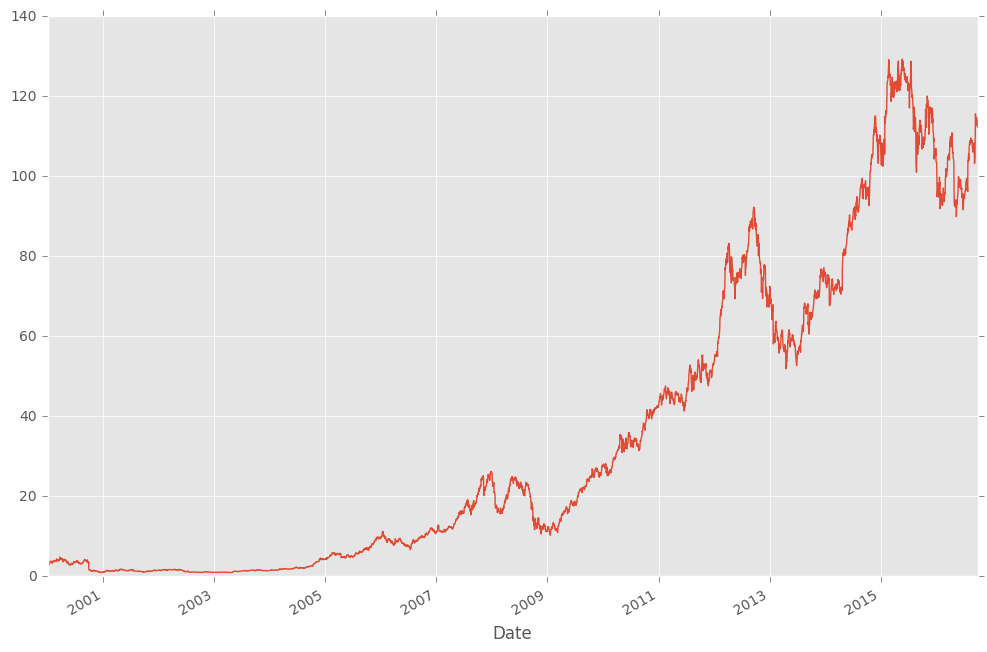

In [10]:
# Sample for Yahoo Historical Data Retrieval
start = datetime(2000,1,1)
end = datetime(2016,10,1)

stock = "aapl"
stock_data = web.DataReader(stock, "yahoo", start, end)
stock_data["Adj Close"].plot(figsize=(12,8));

## Universe Definition
The following dictionary maps the selected stocks to their respective industry. This is important, since I'm expecting that some alphas will be more predivitve for certain industries than others.

In [2]:
stock_universe = {'A': 4, 'AA': 7, 'AAL': 5, 'AAP': 0, 'AAPL': 6, 'ABBV': 4, 'ABC': 4, 'ABT': 4, 'ACN': 6, 'ADBE': 6, 
'ADI': 6, 'ADM': 1, 'ADP': 6, 'ADS': 6, 'ADSK': 6, 'AEE': 9, 'AEP': 9, 'AES': 9, 'AET': 4, 'AFL': 3, 
'AGN': 4, 'AIG': 3, 'AIV': 3, 'AIZ': 3, 'AJG': 3, 'AKAM': 6, 'ALK': 5, 'ALL': 3, 'ALLE': 5, 'ALXN': 4,
'AMAT': 6, 'AME': 5, 'AMG': 3, 'AMGN': 4, 'AMP': 3, 'AMT': 3, 'AMZN': 0, 'AN': 0, 'ANTM': 4, 'AON': 3,
'APA': 2, 'APC': 2, 'APD': 7, 'APH': 5, 'ATVI': 6, 'AVB': 3, 'AVGO': 6, 'AVY': 7, 'AWK': 9, 'AXP': 3,
'AYI': 5, 'AZO': 0, 'BA': 5, 'BAC': 3, 'BAX': 4, 'BBBY': 0, 'BBT': 3, 'BBY': 0, 'BCR': 4, 'BDX': 4,
'BEN': 3, 'BF-B': 1, 'BHI': 2, 'BIIB': 4, 'BK': 3, 'BLK': 3, 'BLL': 7, 'BMY': 4, 'BRK-B': 3, 'BSX': 4,
'BWA': 0, 'BXP': 3, 'C': 3, 'CA': 6, 'CAG': 1, 'CAH': 4, 'CAT': 5, 'CB': 3, 'CBG': 3, 'CBS': 0, 
'CCI': 3, 'CCL': 0, 'CELG': 4, 'CERN': 4, 'CF': 7, 'CFG': 3, 'CHD': 1, 'CHK': 2, 'CHRW': 5, 'CI': 4,
'CINF': 3, 'CL': 1, 'CLX': 1, 'CMA': 3, 'CMCSA': 0, 'CME': 3, 'CMG': 0, 'CMI': 5, 'CMS': 9, 'CNC': 4,
'CNP': 9, 'COF': 3, 'COG': 2, 'COH': 0, 'COL': 5, 'COP': 2, 'COST': 1, 'CPB': 1, 'CRM': 6,
'CSCO': 6, 'CSRA': 6, 'CSX': 5, 'CTAS': 5, 'CTL': 8, 'CTSH': 6, 'CTXS': 6, 'CVS': 1, 'CVX': 2, 
'CXO': 2, 'D': 9, 'DAL': 5, 'DD': 7, 'DE': 5, 'DFS': 3, 'DG': 0, 'DGX': 4, 'DHI': 0, 'DHR': 5, 
'DIS': 0, 'DISCA': 0, 'DISCK': 0, 'DLPH': 0, 'DLR': 3, 'DLTR': 0, 'DNB': 5, 'DO': 2, 'DOV': 5, 
'DOW': 7, 'DPS': 1, 'DRI': 0, 'DTE': 9, 'DUK': 9, 'DVA': 4, 'DVN': 2, 'EA': 6, 'EBAY': 6, 'ECL': 7,
'ED': 9, 'EFX': 3, 'EIX': 9, 'EL': 1, 'EMC': 6, 'EMN': 7, 'EMR': 5, 'ENDP': 4, 'EOG': 2, 'EQIX': 6,
'EQR': 3, 'EQT': 2, 'ES': 9, 'ESRX': 4, 'ESS': 3, 'ETFC': 3, 'ETN': 5, 'ETR': 9, 'EW': 4, 'EXC': 9,
'EXPD': 5, 'EXPE': 0, 'EXR': 3, 'F': 0, 'FAST': 5, 'FB': 6, 'FBHS': 5, 'FCX': 7, 'FDX': 5, 'FE': 9, 
'FFIV': 6, 'FIS': 6, 'FISV': 6, 'FITB': 3, 'FL': 0, 'FLIR': 5, 'FLR': 5, 'FLS': 5, 'FMC': 7, 
'FOX': 0, 'FOXA': 0, 'FRT': 3, 'FSLR': 6, 'FTI': 2, 'FTR': 8, 'GD': 5, 'GE': 5, 'GGP': 3,
'GILD': 4, 'GIS': 1, 'GLW': 5, 'GM': 0, 'GOOG': 6, 'GOOGL': 6, 'GPC': 0, 'GPN': 6, 'GPS': 0, 
'GRMN': 0, 'GS': 3, 'GT': 0, 'GWW': 5, 'HAL': 2, 'HAR': 0, 'HAS': 0, 'HBAN': 3, 'HBI': 0, 'HCA': 4,
'HCN': 3, 'HCP': 3, 'HD': 0, 'HES': 2, 'HIG': 3, 'HOG': 0, 'HOLX': 4, 'HON': 5, 'HOT': 0, 'HP': 2,
'HPE': 6, 'HPQ': 6, 'HRB': 3, 'HRL': 1, 'HRS': 6, 'HSIC': 4, 'HST': 3, 'HSY': 1, 'HUM': 4, 'IBM': 6,
'ICE': 3, 'IFF': 7, 'ILMN': 4, 'INTC': 6, 'INTU': 6, 'IP': 7, 'IPG': 0, 'IR': 5, 'IRM': 5, 
'ISRG': 4, 'ITW': 5, 'IVZ': 3, 'JBHT': 5, 'JCI': 0, 'JEC': 5, 'JNJ': 4, 'JNPR': 6, 'JPM': 3, 
'JWN': 0, 'K': 1, 'KEY': 3, 'KHC': 1, 'KIM': 3, 'KLAC': 6, 'KMB': 1, 'KMI': 2, 'KMX': 0, 'KO': 1,
'KORS': 0, 'KR': 1, 'KSS': 0, 'KSU': 5, 'L': 3, 'LB': 0, 'LEG': 5, 'LEN': 0, 'LH': 4, 'LKQ': 0, 
'LLL': 5, 'LLTC': 6, 'LLY': 4, 'LM': 3, 'LMT': 5, 'LNC': 3, 'LOW': 0, 'LRCX': 6, 'LUK': 3, 'LUV': 5,
'LVLT': 8, 'LYB': 7, 'M': 0, 'MA': 6, 'MAC': 3, 'MAR': 0, 'MAS': 5, 'MAT': 0, 'MCD': 0, 'MCHP': 6, 
'MCK': 4, 'MCO': 3, 'MDLZ': 1, 'MDT': 4, 'MET': 3, 'MHK': 0, 'MJN': 1, 'MKC': 1, 'MLM': 7, 'MMC': 3, 
'MMM': 5, 'MNK': 4, 'MNST': 1, 'MO': 1, 'MON': 7, 'MOS': 7, 'MPC': 2, 'MRK': 4, 'MRO': 2, 'MS': 3, 
'MSFT': 6, 'MSI': 6, 'MTB': 3, 'MU': 6, 'MUR': 2, 'MYL': 4, 'NAVI': 3, 'NBL': 2, 'NDAQ': 3,
'NEM': 7, 'NFLX': 6, 'NFX': 2, 'NI': 9, 'NKE': 0, 'NLSN': 5, 'NOC': 5, 'NOV': 2, 'NRG': 9, 'NSC': 5, 
'NTAP': 6, 'NTRS': 3, 'NUE': 7, 'NVDA': 6, 'NWL': 0, 'NWS': 0, 'NWSA': 0, 'O': 3, 'OI': 7, 'OKE': 2, 
'OMC': 0, 'ORCL': 6, 'ORLY': 0, 'OXY': 2, 'PAYX': 6, 'PBCT': 3, 'PBI': 5, 'PCAR': 5, 'PCG': 9, 'PCLN': 0, 
'PDCO': 4, 'PEG': 9, 'PEP': 1, 'PFE': 4, 'PFG': 3, 'PG': 1, 'PGR': 3, 'PH': 5, 
'PHM': 0, 'PKI': 4, 'PLD': 3, 'PM': 1, 'PNC': 3, 'PNR': 5, 'PNW': 9, 'PPG': 7, 
'PPL': 9, 'PRGO': 4, 'PRU': 3, 'PSA': 3, 'PSX': 2, 'PVH': 0, 'PWR': 5, 'PX': 7, 'PXD': 2, 
'PYPL': 6, 'QCOM': 6, 'QRVO': 6, 'R': 5, 'RAI': 1, 'RCL': 0, 'REGN': 4, 'RF': 3, 'RHI': 5, 'RHT': 6, 
'RIG': 2, 'RL': 0, 'ROK': 5, 'ROP': 5, 'ROST': 0, 'RRC': 2, 'RSG': 5, 'RTN': 5, 'SBUX': 0, 'SCG': 9,
'SCHW': 3, 'SE': 2, 'SEE': 7, 'SHW': 7, 'SIG': 0, 'SJM': 1, 'SLB': 2, 'SLG': 3, 'SNA': 0, 'SNI': 0,
'SO': 9, 'SPG': 3, 'SPGI': 3, 'SPLS': 0, 'SRCL': 5, 'SRE': 9, 'STI': 3, 'STJ': 4, 'STT': 3, 'STX': 6,
'STZ': 1, 'SWK': 0, 'SWKS': 6, 'SWN': 2, 'SYF': 3, 'SYK': 4, 'SYMC': 6, 'SYY': 1, 'T': 8, 'TAP': 1,
'TDC': 6, 'TDG': 5, 'TEL': 6, 'TGNA': 0, 'TGT': 0, 'TIF': 0, 'TJX': 0, 'TMK': 3, 'TMO': 4,
'TRIP': 0, 'TROW': 3, 'TRV': 3, 'TSCO': 0, 'TSN': 1, 'TSO': 2, 'TSS': 6, 'TWX': 0, 'TXN': 6, 'TXT': 5,
'TYC': 5, 'UA': 0, 'UAL': 5, 'UDR': 3, 'UHS': 4, 'ULTA': 0, 'UNH': 4, 'UNM': 3, 'UNP': 5, 'UPS': 5,
'URBN': 0, 'URI': 5, 'USB': 3, 'UTX': 5, 'V': 6, 'VAR': 4, 'VFC': 0, 'VIAB': 0, 'VLO': 2, 'VMC': 7, 
'VNO': 3, 'VRSK': 5, 'VRSN': 6, 'VRTX': 4, 'VTR': 3, 'VZ': 8, 'WAT': 4, 'WBA': 1, 'WDC': 6, 'WEC': 9,
'WFC': 3, 'WFM': 1, 'WHR': 0, 'WM': 5, 'WMB': 2, 'WMT': 1, 'WRK': 7, 'WU': 6, 'WY': 3, 
'WYN': 0, 'WYNN': 0, 'XEC': 2, 'XEL': 9, 'XL': 3, 'XLNX': 6, 'XOM': 2, 'XRAY': 4, 'XRX': 6, 'XYL': 5,
 'YHOO': 6, 'YUM': 0, 'ZBH': 4, 'ZION': 3, 'ZTS': 4}

In [3]:
sector_names = {0: 'Consumer Discretionary',
                1: 'Consumer Staples',
                2: 'Energy',
                3: 'Financials',
                4: 'Health Care',
                5: 'Industrials',
                6: 'Information Technology',
                7: 'Materials',
                8: 'Telecommunications Services',
                9: 'Utilities'}

## Benchmark Model